In [265]:
import numpy as np
import matplotlib.pyplot as plt
from load import load_daily_generation_data

# Linear Regression

In [266]:
data = load_daily_generation_data('.\Data\gen_2021.csv')
day_of_week = np.array([ts.weekday() for ts in data['timestamps']])
day_of_month = np.array([ts.day - 1 for ts in data['timestamps']])
month = np.array([ts.month - 1 for ts in data['timestamps']])

def get_one_hot(targets, nb_classes):
    res = np.eye(nb_classes)[np.array(targets).reshape(-1)]
    return res.reshape(list(targets.shape)+[nb_classes])

day_of_week_1h = get_one_hot(day_of_week, 7)
day_of_month_1h = get_one_hot(day_of_month, 31)
month_1h = get_one_hot(month, 12)

X_1h = np.concatenate((day_of_week_1h, day_of_month_1h, month_1h), axis=1)

[400361.70000000007, 414680.50000000006, 490428.8, 531699.2000000001, 564399.9, 576347.4999999999, 595178.1, 569969.8, 552886.1000000001, 633039.0000000002]


Score for total: 0.7534328058396861
Score for renewables: 0.2729333071818876
Score for non_renewables: 0.7569385179157351
Score for wind: 0.3308122256784941
Score for coal: 0.7870382005492849


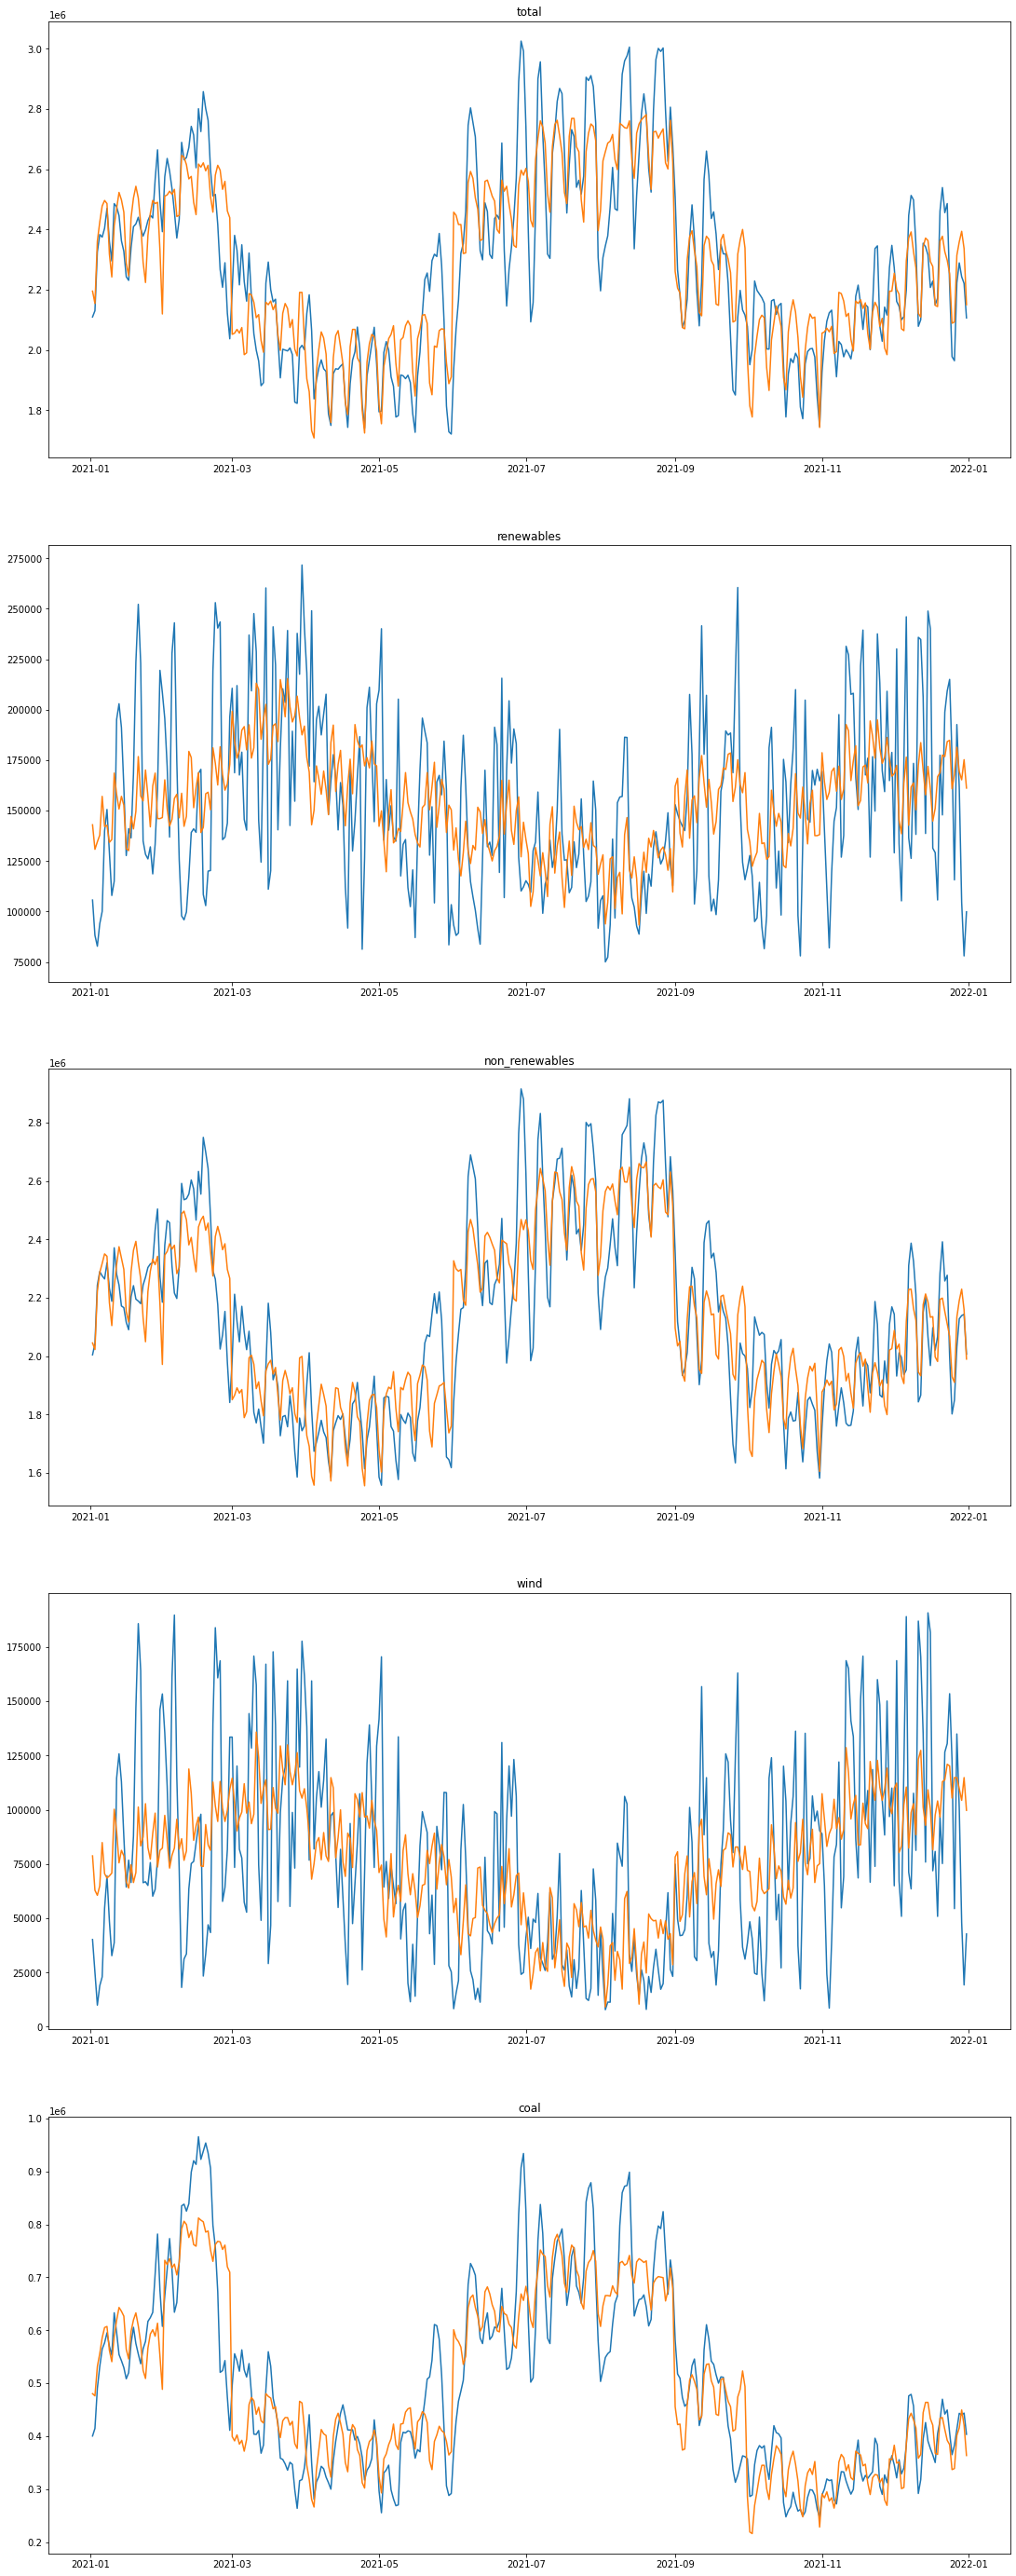

In [153]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

power_sources = ['total', 'renewables', 'non_renewables', 'wind', 'coal']
fig, axs = plt.subplots(len(power_sources))
fig.set_size_inches(18.5, 10 * len(power_sources))
for i, power_source in enumerate(power_sources):
    reg = LinearRegression().fit(X_1h, data[power_source])
    y_pred_1h = reg.predict(X_1h)
    print(f'Score for {power_source}: {reg.score(X_1h, np.array(data[power_source]))}')
    axs[i].plot(data['timestamps'], data[power_source])
    axs[i].plot(data['timestamps'], y_pred_1h)
    axs[i].set_title(power_source)


# Gaussian Process using datetime

In [267]:
import GPy
GPy.plotting.change_plotting_library('plotly_offline')

In [268]:
def format_input(series, normalization_const = None):
    series = np.array(series).reshape(-1, 1)
    series_min = np.min(series)
    if not normalization_const:
        normalization_const = np.max(series) - series_min
    return (series - series_min)/normalization_const

def train_gp(x, y):
    input_dims = x.shape[1]
    kernel_rbf = GPy.kern.RBF(input_dim=input_dims, variance=1, lengthscale=1)
    kernel_lin = GPy.kern.Linear(input_dim=input_dims)
    kernel = kernel_lin + kernel_rbf

    m = GPy.models.GPRegression(x, y,kernel)

    m.optimize(messages=True)
    m.optimize_restarts(num_restarts = 3)
    return m

In [212]:
x = format_input([ts.timestamp() for ts in data['timestamps']])
y = format_input(data['total'])
m = train_gp(x, y)

Optimization restart 1/3, f = -151.75420464788573
Optimization restart 2/3, f = 50.26500254994909
Optimization restart 3/3, f = 50.26500255085554


In [213]:
def evaluate_model(x, y, m, title='GP prediction vs data'):
    gp_pred = m.predict(x)
    plt.plot(data['timestamps'], y)
    plt.plot(data['timestamps'], gp_pred[0])
    fig = plt.gcf()
    fig.set_size_inches(20, 8)
    fig.suptitle(title)
    plt.show()
    print(f'Loss: {mean_squared_error(y, gp_pred[0])}')

Loss: 0.020592804462130652


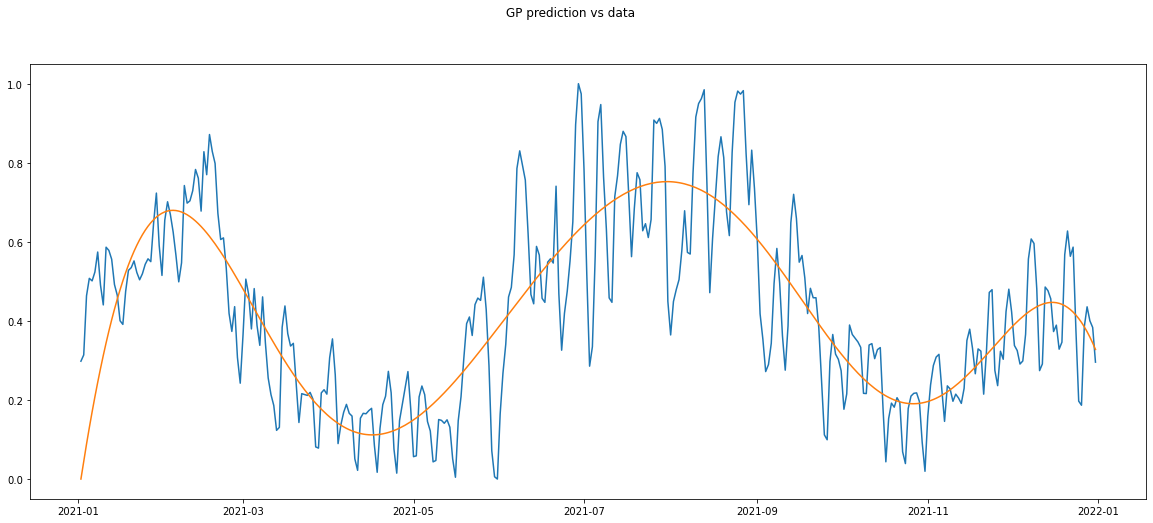

In [165]:
evaluate_model(x, y, m)

# Gaussian Process using decomposed dates

In [270]:
def normalize(arr):
    min = np.min(arr)
    max = np.max(arr)
    return ((np.array(arr, ndmin=2) - min)/(max-min)).T

x = np.concatenate((normalize(day_of_week),
                    normalize(day_of_month),
                    normalize(month)),axis=1)

Optimization restart 1/3, f = -124.51366587311114
Optimization restart 2/3, f = -124.51366587642838
Optimization restart 3/3, f = -115.23198408265824


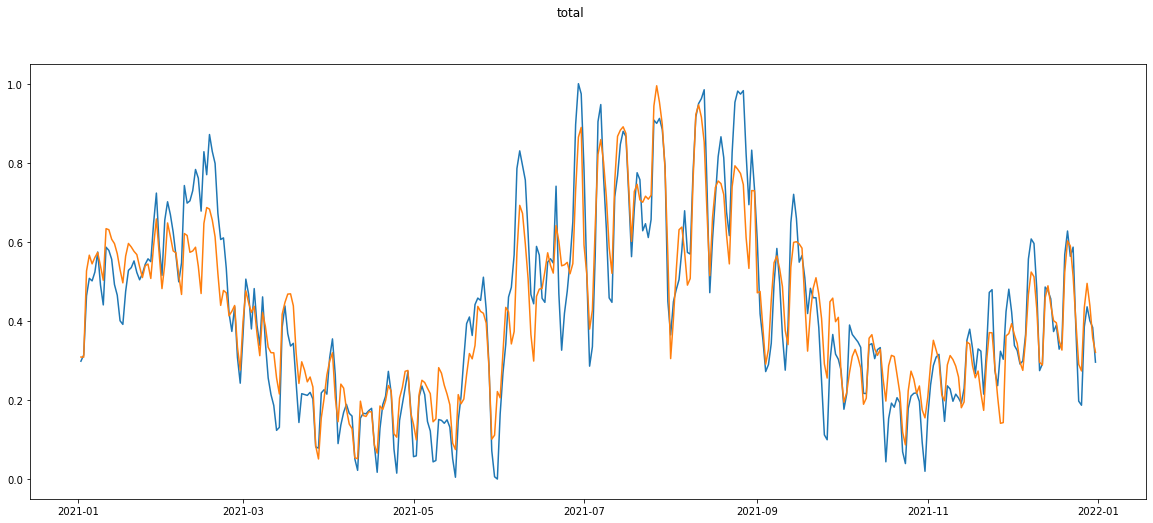

Loss: 0.006994418019234019


Optimization restart 1/3, f = -37.77792046299402
Optimization restart 2/3, f = -37.77792046273851
Optimization restart 3/3, f = -37.777920460890755


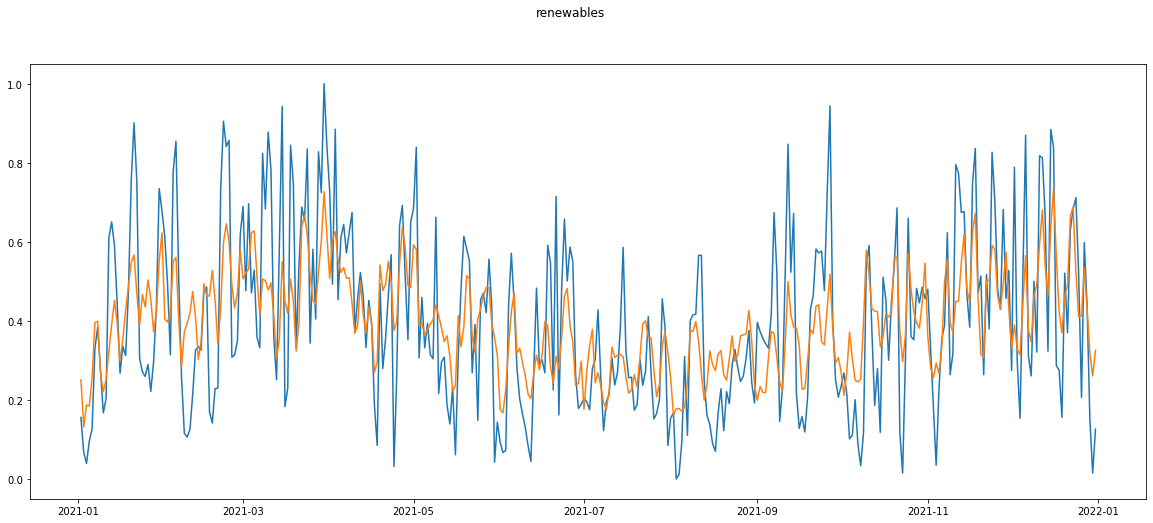

Loss: 0.024780329074035875


Optimization restart 1/3, f = -127.19570593178153
Optimization restart 2/3, f = -127.19570593181126
Optimization restart 3/3, f = -127.19570593179816


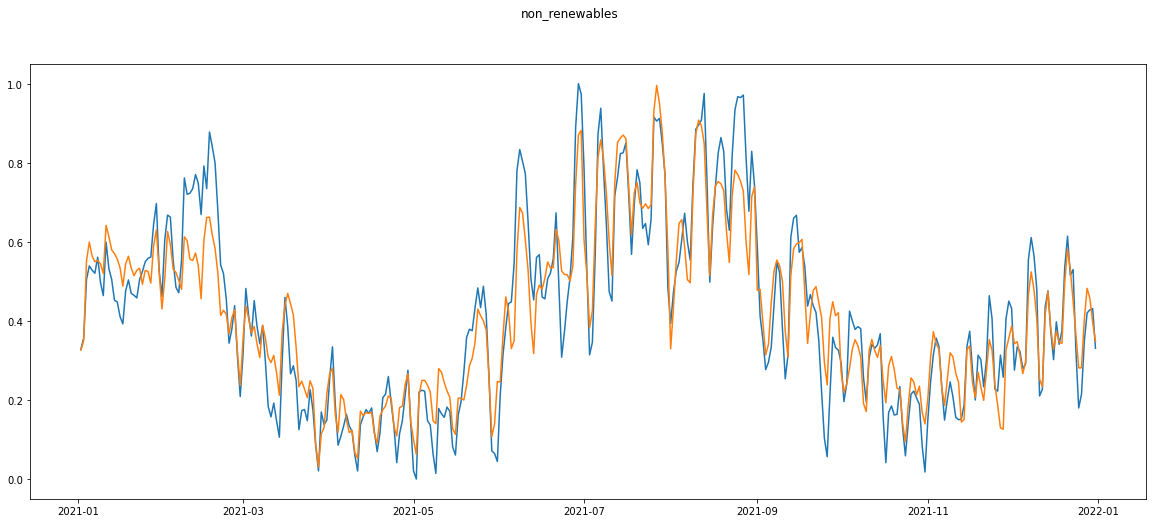

Loss: 0.007042021190171187


Optimization restart 1/3, f = -20.650566582341753
Optimization restart 2/3, f = -20.65056653401723
Optimization restart 3/3, f = -20.65056658234181


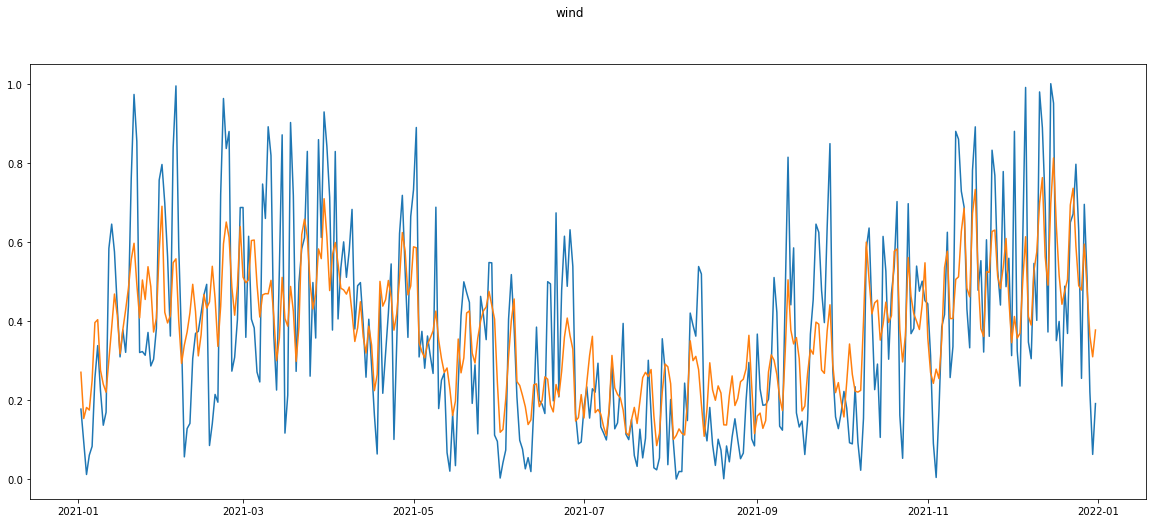

Loss: 0.027003083131438517


Optimization restart 1/3, f = -120.1528734796436
Optimization restart 2/3, f = -120.15287348420051
Optimization restart 3/3, f = -120.15287348412141


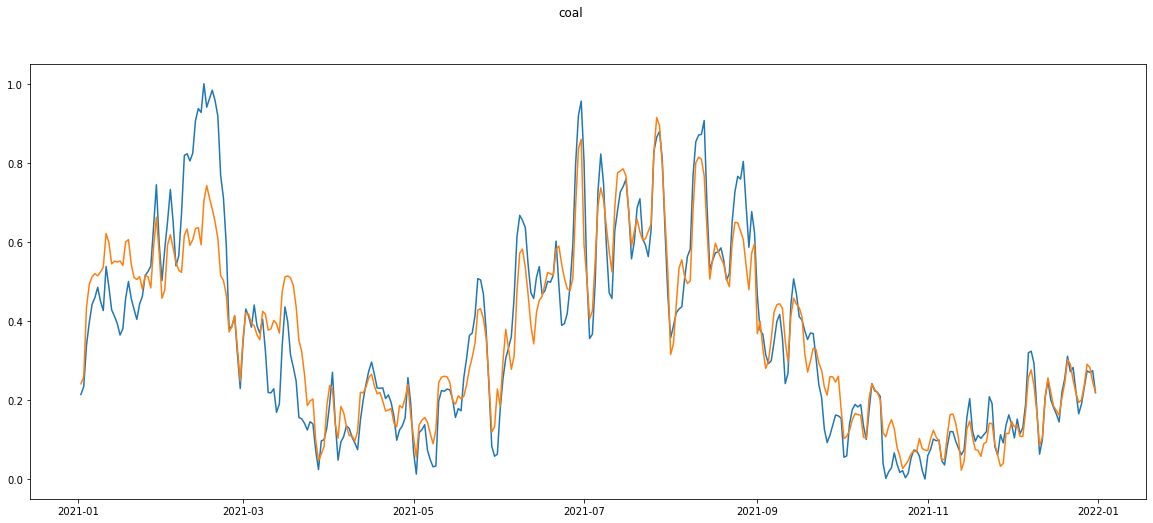

Loss: 0.007577896646754258


In [272]:
for power_source in power_sources:
    y = format_input(data[power_source])
    m = train_gp(x, y)
    evaluate_model(x, y, m, title=power_source)

## Updated Kernel

In [273]:
def train_gp_v2(x, y):
    input_dims = x.shape[1]
    kernel_rbf = GPy.kern.Matern32(input_dim=input_dims)
    kernel_lin = GPy.kern.Linear(input_dim=input_dims)
    kernel_white = GPy.kern.White(input_dim=input_dims, variance=1)
    kernel = kernel_rbf + kernel_lin + kernel_white

    m = GPy.models.GPRegression(x, y, kernel)

    m.optimize(messages=True)
    m.optimize_restarts(num_restarts = 3)
    return m

Optimization restart 1/3, f = -114.85084881251893
Optimization restart 2/3, f = -114.85084881037267
Optimization restart 3/3, f = -114.85084881141137


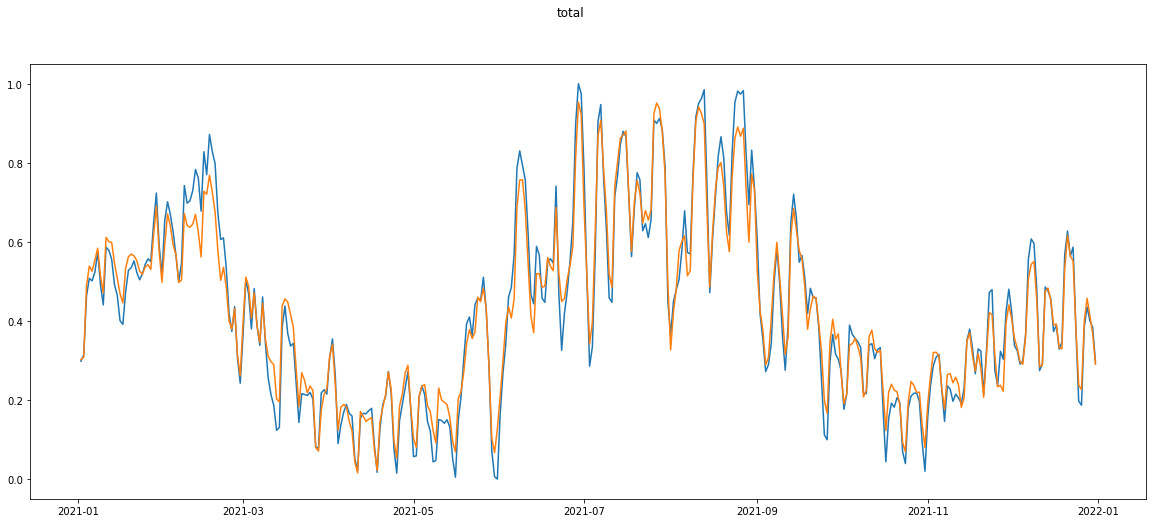

Loss: 0.0020140491312505256


Optimization restart 1/3, f = -39.10403053073304
Optimization restart 2/3, f = -39.1040305360153
Optimization restart 3/3, f = -39.10403053589721


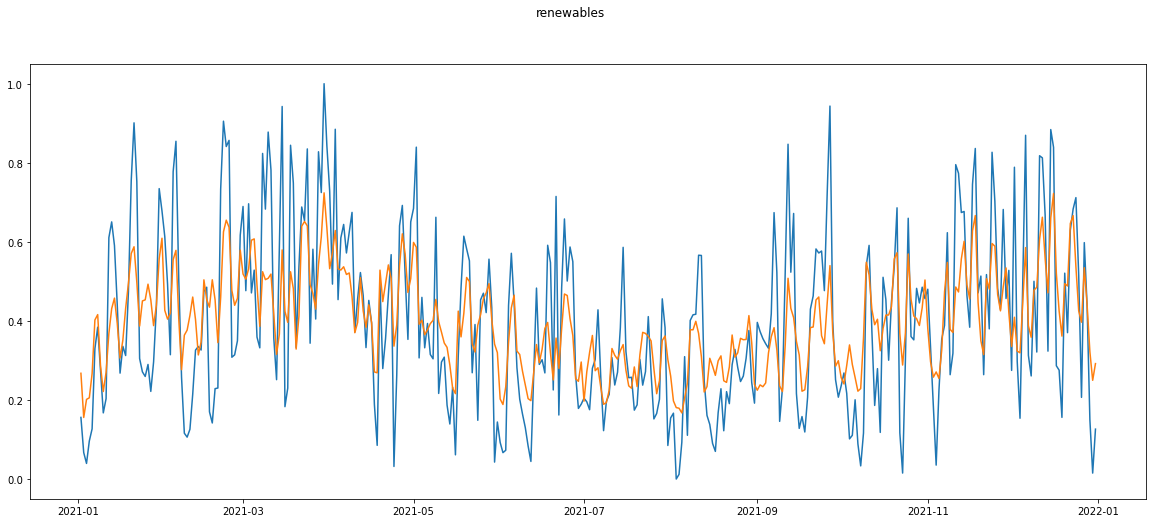

Loss: 0.021415316487786173


Optimization restart 1/3, f = -117.16132246714511
Optimization restart 2/3, f = -117.16132246757428
Optimization restart 3/3, f = -117.16132246080485


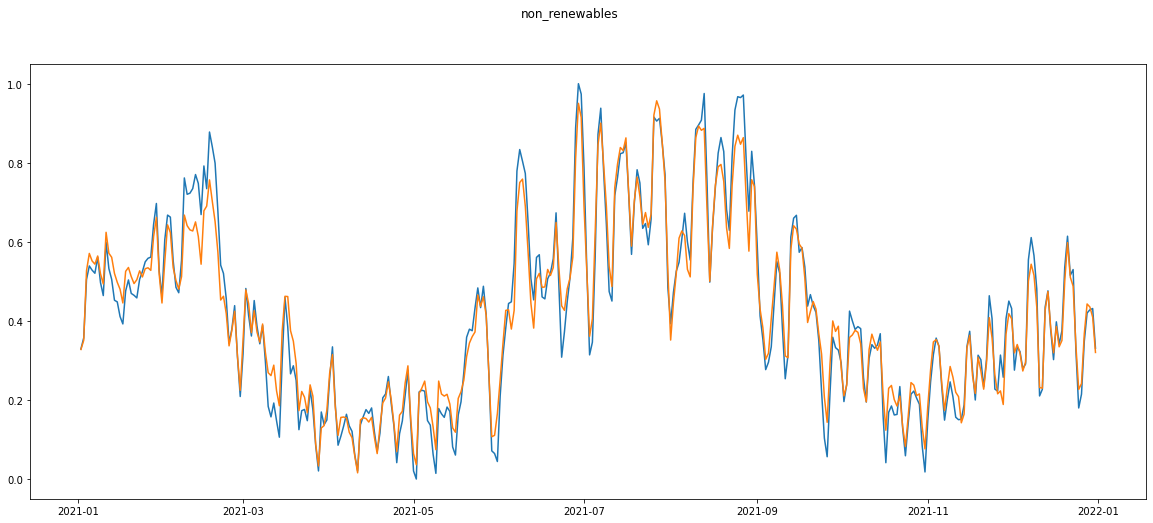

Loss: 0.0022592708654922498


Optimization restart 1/3, f = -21.40687999194722
Optimization restart 2/3, f = -21.406879991947505
Optimization restart 3/3, f = -21.40687999183902


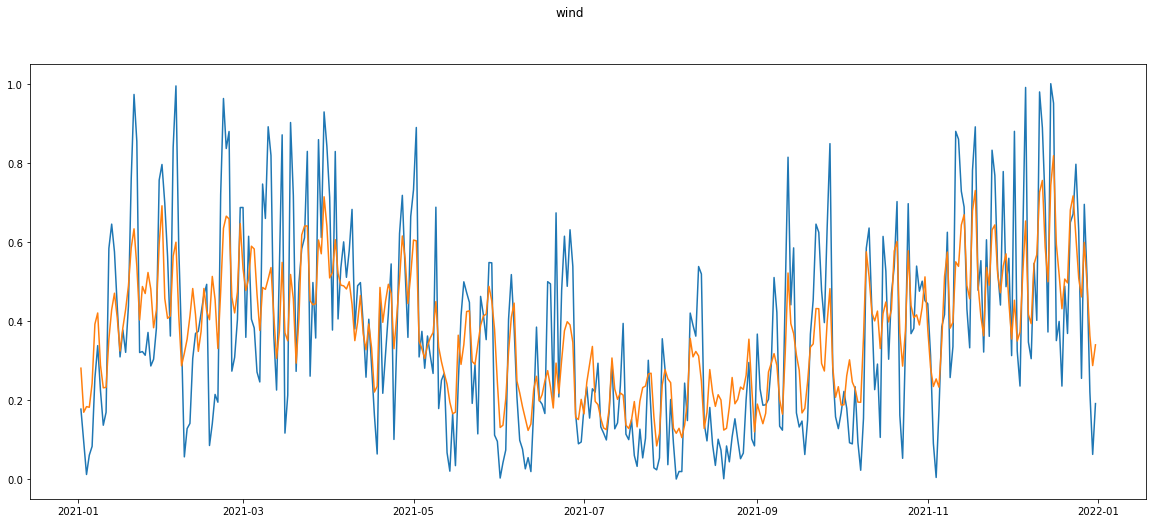

Loss: 0.021834285547196675


Optimization restart 1/3, f = -102.34503398339012
Optimization restart 2/3, f = -102.34503398331447
Optimization restart 3/3, f = -102.34503398329224


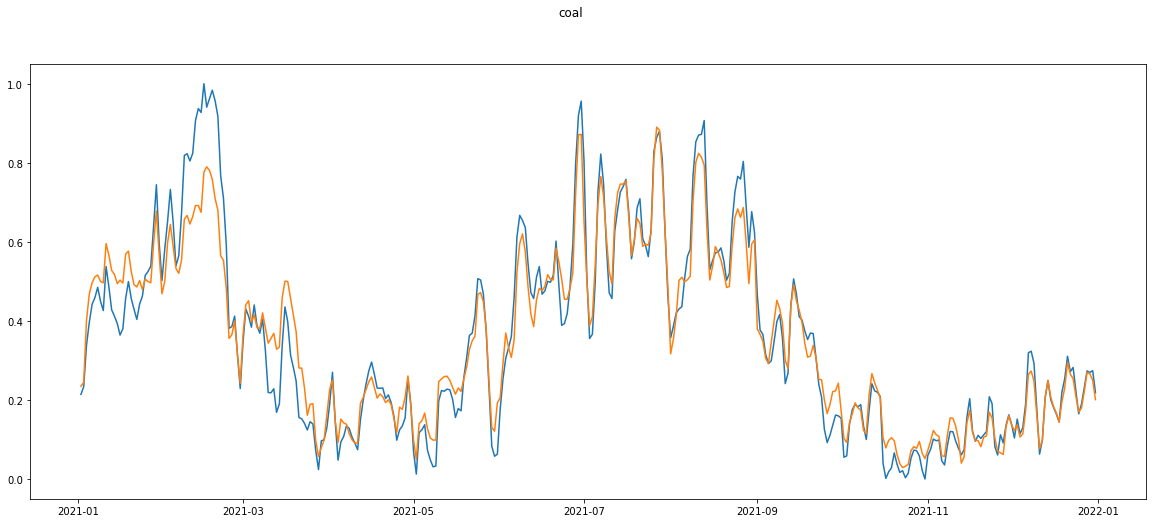

Loss: 0.004227241219401713


In [281]:
x = np.concatenate((normalize(month), normalize(day_of_month), normalize(day_of_week)), axis=1)
x_noisy = x + np.random.normal(0, 0.005, size=x.shape)
models = {}

for power_source in power_sources:
    y = format_input(data[power_source])
    models[power_source] = train_gp_v2(x_noisy, y)
    evaluate_model(x, y, models[power_source], title=power_source)

# Periodic Kernel

In [314]:
x = format_input([ts.timestamp() for ts in data['timestamps']])
month = 1.0 / 12
week = (1.0 / 365) * 7

0.08333333333333333
[1.]


In [315]:
def train_periodic_gp(x, y):
    input_dims = x.shape[1]
    periodic_kernel_week = GPy.kern.StdPeriodic(input_dim=input_dims, period=week)
    periodic_kernel_month = GPy.kern.StdPeriodic(input_dim=input_dims, period=week)
    rbf_kernel = GPy.kern.Matern32(input_dim=input_dims)
    kernel = periodic_kernel_month + periodic_kernel_week + rbf_kernel

    m = GPy.models.GPRegression(x, y, kernel)

    m.optimize(messages=True)
    m.optimize_restarts(num_restarts = 3)
    return m

Optimization restart 1/3, f = -424.99101531980716
Optimization restart 2/3, f = -353.53289931529287
Optimization restart 3/3, f = -379.57971594361544


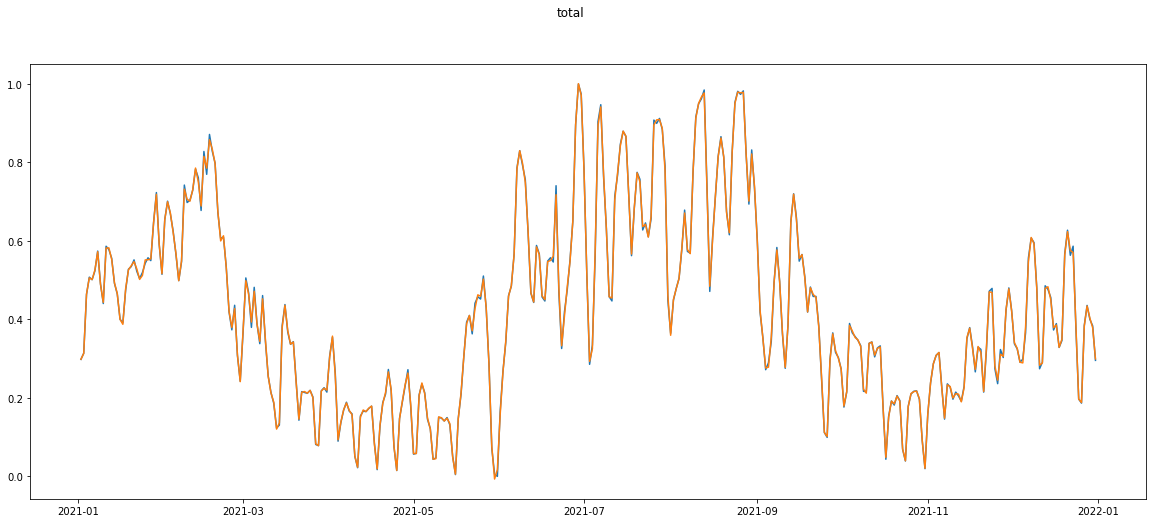

Loss: 2.7464867696422207e-05


Optimization restart 1/3, f = -87.7423016956667
Optimization restart 2/3, f = -91.97487783000332
Optimization restart 3/3, f = -65.2950620883737


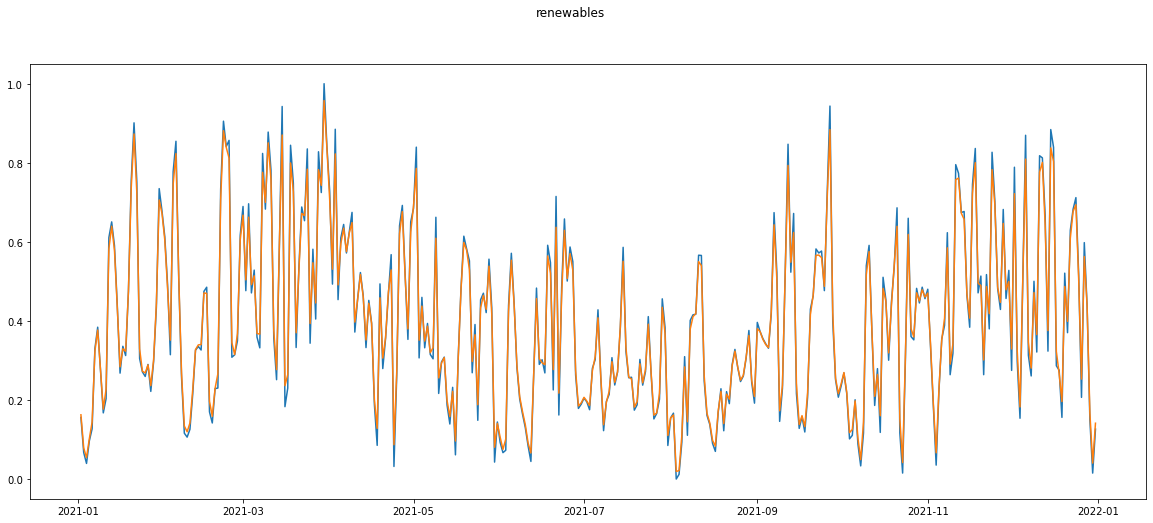

Loss: 0.0005607210886263524


C:\Users\pedro\anaconda3\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:

overflow encountered in expm1



Optimization restart 1/3, f = -353.6569246087428
Optimization restart 2/3, f = -353.6568624441061
Optimization restart 3/3, f = -375.9969384241038


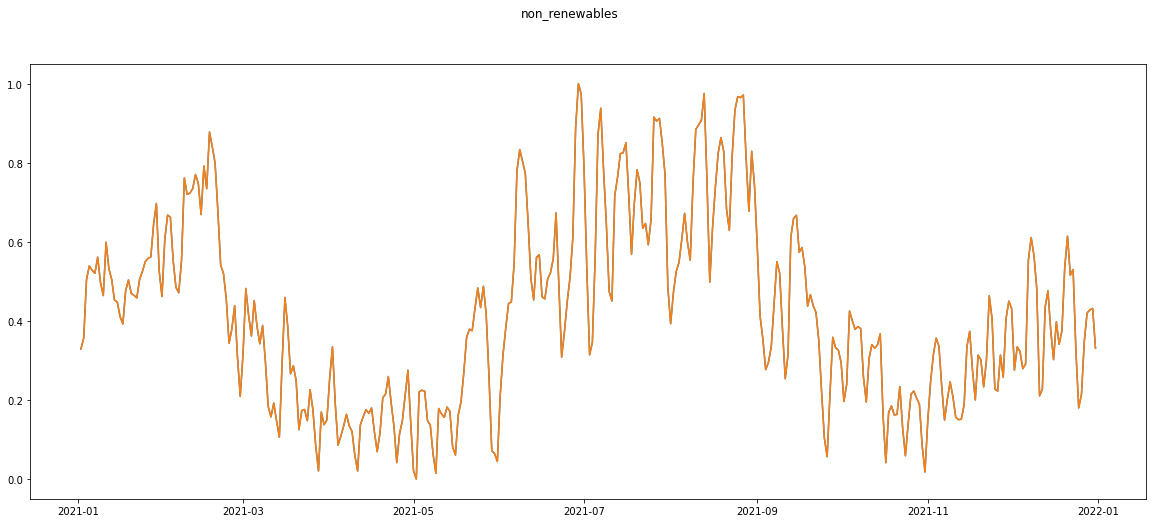

Loss: 3.10507413555324e-14


Optimization restart 1/3, f = -58.849218449956965
Optimization restart 2/3, f = -58.807511357183955
Optimization restart 3/3, f = -75.15904858573538


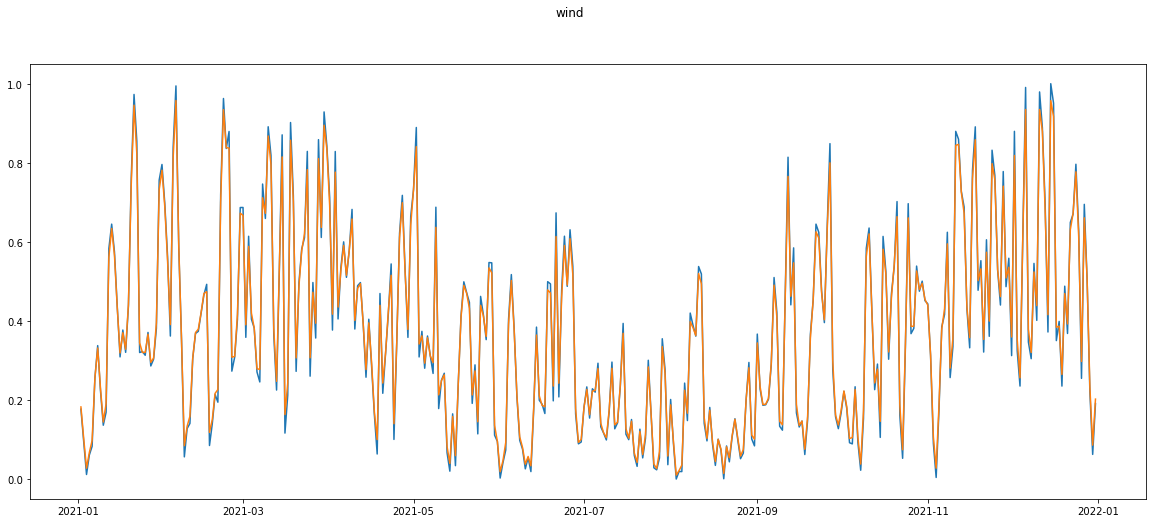

Loss: 0.00042860164813007546


Optimization restart 1/3, f = -540.3844006070055
Optimization restart 2/3, f = -509.11479092305865
Optimization restart 3/3, f = -509.1523306136525


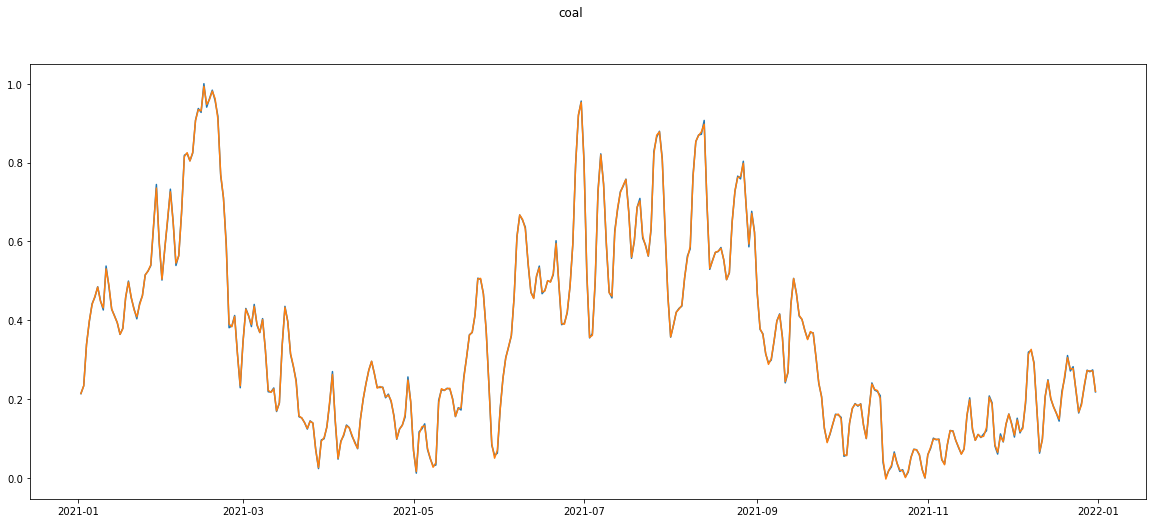

Loss: 1.0638015202511791e-05


In [317]:
periodic_models = {}

for power_source in power_sources:
    y = format_input(data[power_source])
    periodic_models[power_source] = train_periodic_gp(x, y)
    evaluate_model(x, y, periodic_models[power_source], title=power_source)

# Test against 2020 data

In [307]:
test_data = load_daily_generation_data('.\Data\gen_2020.csv')
day_of_week_test = np.array([ts.weekday() for ts in test_data['timestamps']])
day_of_month_test = np.array([ts.day - 1 for ts in test_data['timestamps']])
month_test = np.array([ts.month - 1 for ts in test_data['timestamps']])

x = np.concatenate((normalize(month_test), normalize(day_of_month_test), normalize(day_of_week_test)), axis=1)

[342028.4000000001, 345479.7, 312269.79999999993, 321481.9000000001, 407411.20000000007, 463252.89999999997, 459744.3, 463257.19999999995, 409925.1, 285333.3]


In [310]:
def test_model(x, y, m, title='GP prediction vs data'):
    gp_pred = m.predict(x)
    plt.plot(test_data['timestamps'], y)
    plt.plot(test_data['timestamps'], gp_pred[0])
    fig = plt.gcf()
    fig.set_size_inches(20, 8)
    fig.suptitle(title)
    plt.show()
    print(f'Loss: {mean_squared_error(y, gp_pred[0])}')

(365, 3) (365, 1) (365, 1)


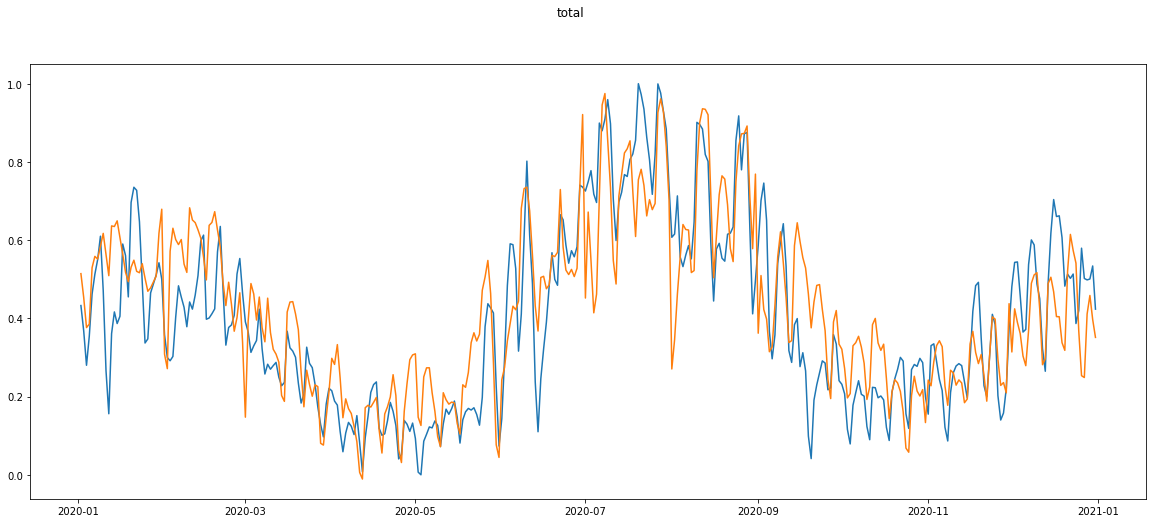

Loss: 0.017646278362335545
(365, 3) (365, 1) (365, 1)


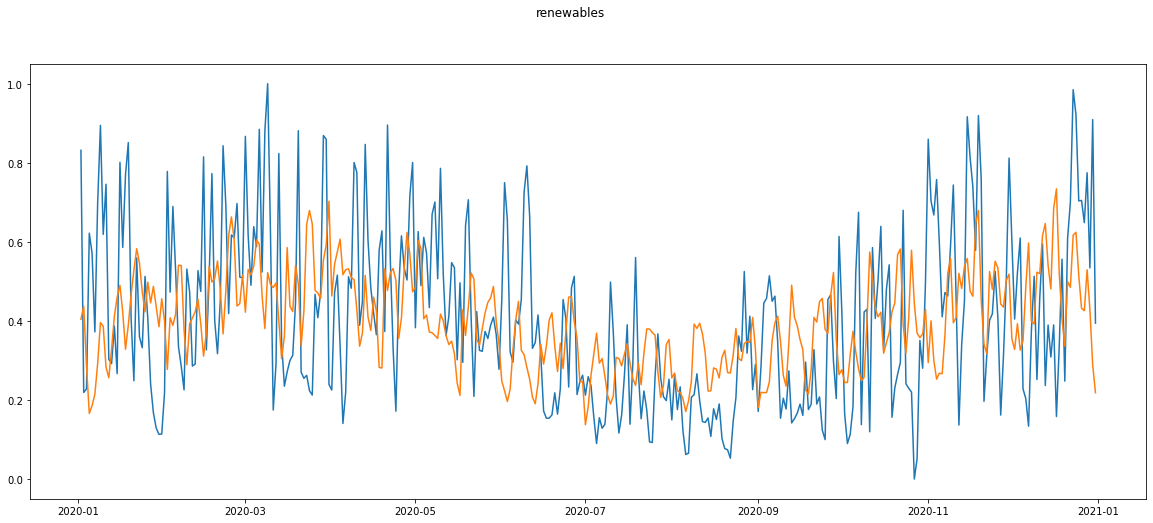

Loss: 0.050378533247711556
(365, 3) (365, 1) (365, 1)


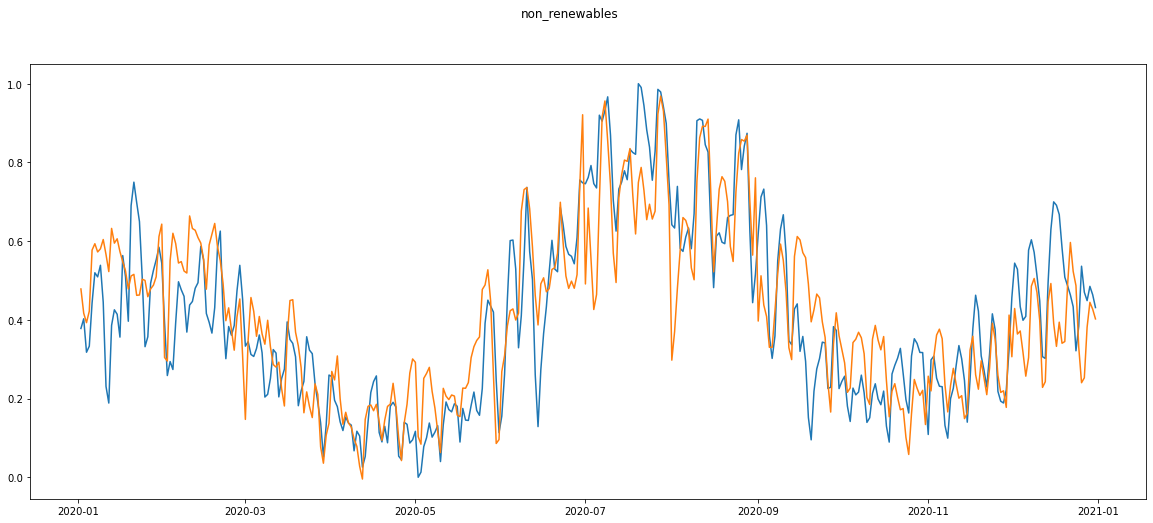

Loss: 0.016882355382678533
(365, 3) (365, 1) (365, 1)


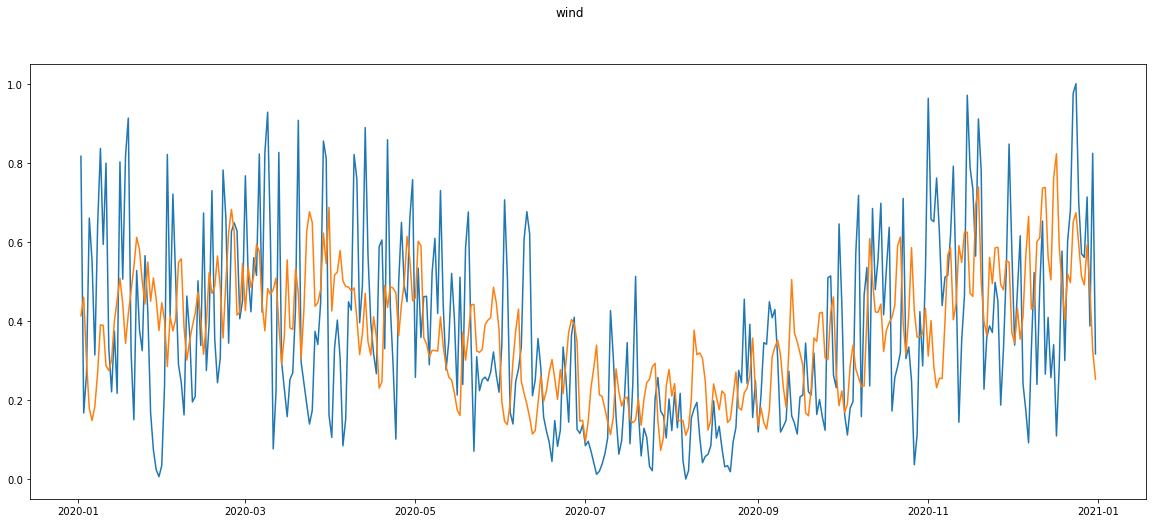

Loss: 0.05498989879520527
(365, 3) (365, 1) (365, 1)


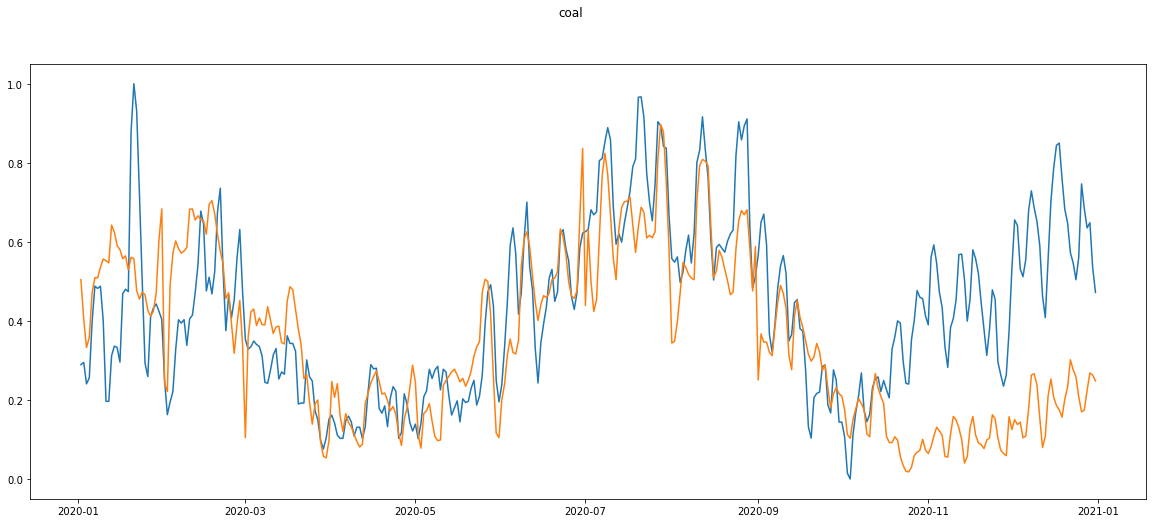

Loss: 0.044205104532022726


In [311]:
for power_source in power_sources:
    y = format_input(test_data[power_source])
    test_model(x, y, models[power_source], title=power_source)

In [318]:
x = format_input([ts.timestamp() for ts in test_data['timestamps']])

(365, 1) (365, 1) (365, 1)


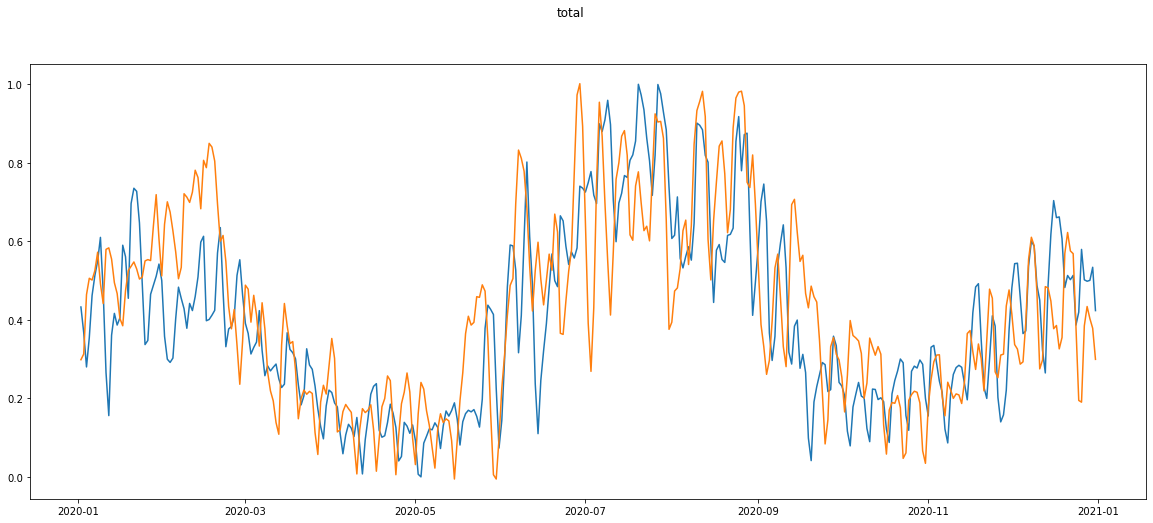

Loss: 0.03246379421253041
(365, 1) (365, 1) (365, 1)


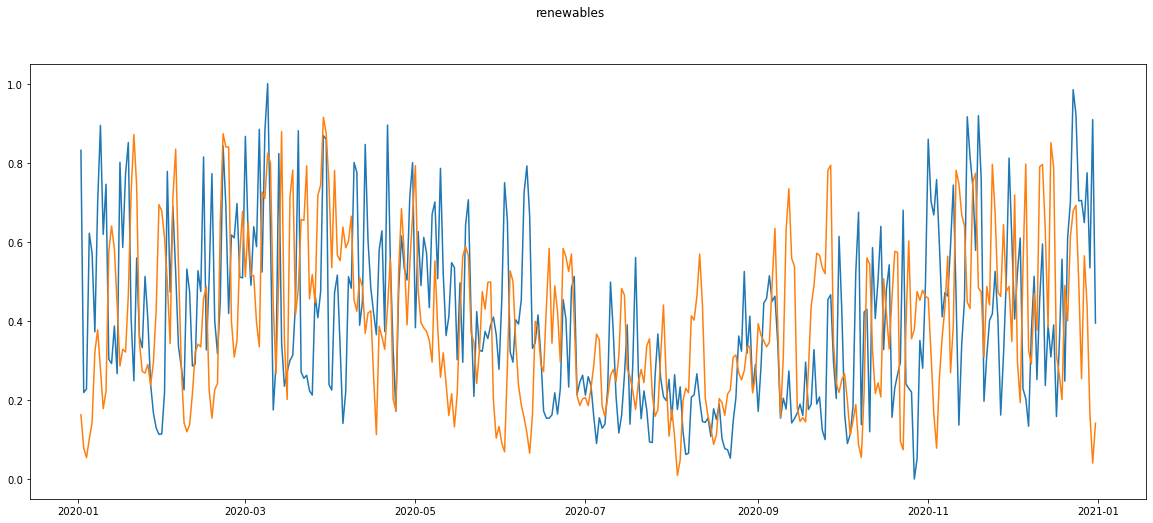

Loss: 0.07496498254070279
(365, 1) (365, 1) (365, 1)


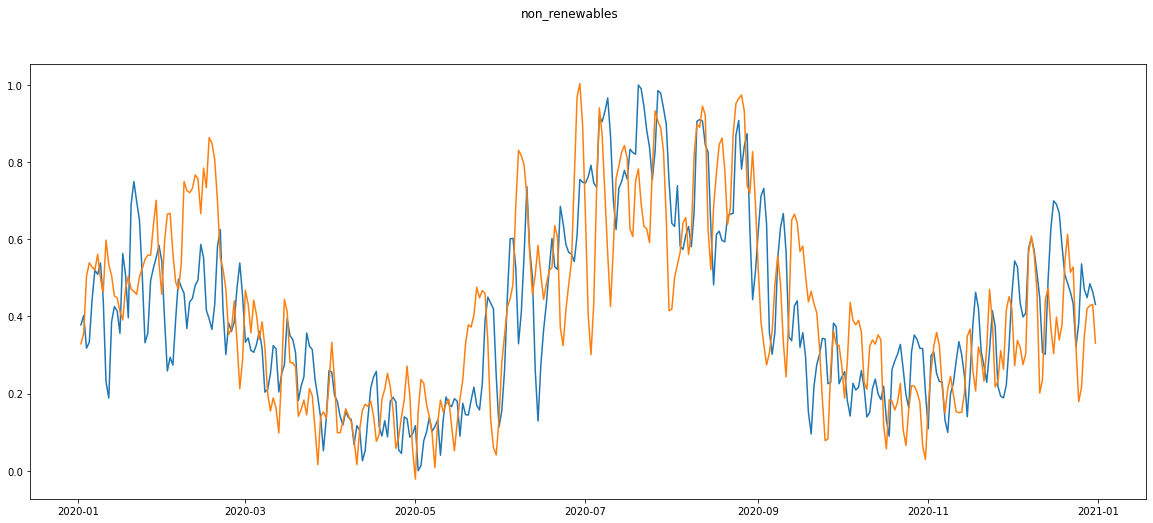

Loss: 0.03050160895257454
(365, 1) (365, 1) (365, 1)


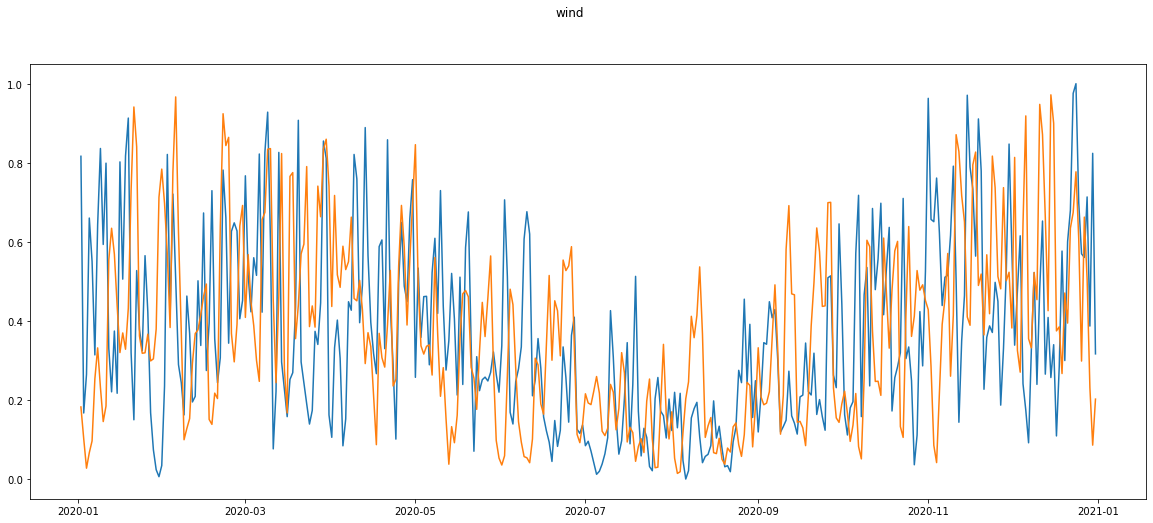

Loss: 0.08333352583870944
(365, 1) (365, 1) (365, 1)


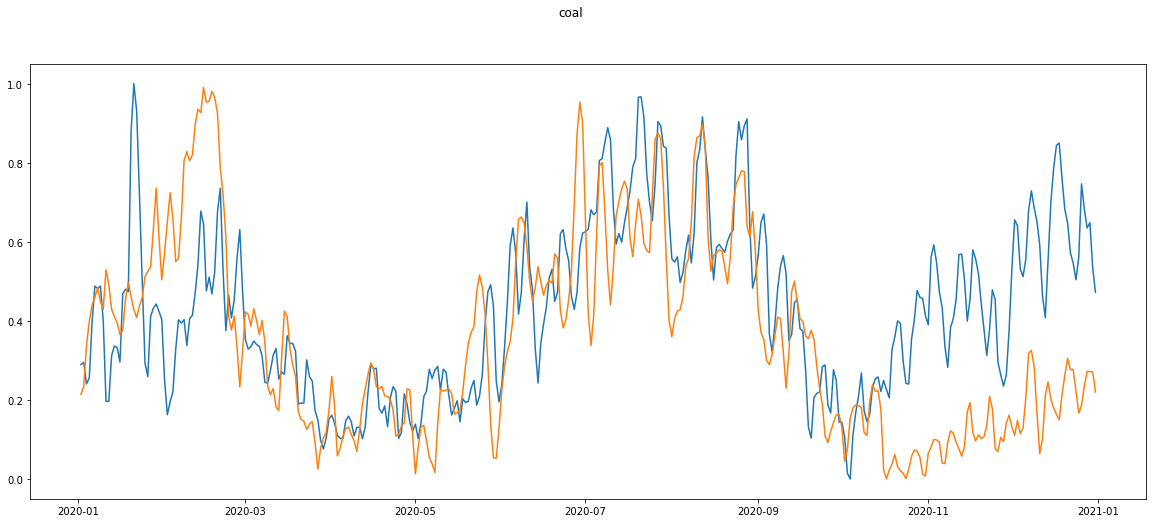

Loss: 0.05602037417272822


In [319]:
for power_source in power_sources:
    y = format_input(test_data[power_source])
    test_model(x, y, periodic_models[power_source], title=power_source)